In [1]:
import numpy as np
from PIL import Image
import pycuda.autoinit
import pycuda.driver as cuda
from pycuda.compiler import SourceModule
import matplotlib.pyplot as plt
import cv2
import time

In [2]:
normal_matmult_kernel_code = """
__global__ void MatrixMulKernel(float* M, float* N, float* P, int Width)
{
    int Row = blockIdx.y * blockDim.y + threadIdx.y;
    int Col = blockIdx.x * blockDim.x + threadIdx.x;
    if ((Row < Width) && (Col < Width))
    {
        float Pvalue = 0;
        for (int k = 0; k < Width; ++k)
        {
            Pvalue += M[Row*Width+k] * N[k*Width+Col];
        }
        P[Row*Width+Col] = Pvalue;
    }
}
"""

In [3]:
tiled_matmult_kernel_code = """

#define TILE_WIDTH 32

__global__ void MatrixMulKernel(float* d_M, float* d_N, float* d_P, int Width)
{
    __shared__ float Mds[TILE_WIDTH][TILE_WIDTH];
    __shared__ float Nds[TILE_WIDTH][TILE_WIDTH];
    
    int Row = blockIdx.y * TILE_WIDTH + threadIdx.y;
    int Col = blockIdx.x * TILE_WIDTH + threadIdx.x;
    
    int tx = threadIdx.x; int ty = threadIdx.y;

    float Pvalue = 0;

    for (int ph = 0; ph < Width/TILE_WIDTH; ++ph)
    {
        Mds[ty][tx] = d_M[Row*Width + ph*TILE_WIDTH + tx];
        Nds[ty][tx] = d_N[(ph*TILE_WIDTH + ty)*Width + Col];
        __syncthreads();
        for (int k = 0; k < TILE_WIDTH; ++k)
        {
            Pvalue += Mds[ty][k] * Nds[k][tx];
        }
        __syncthreads();
    }
    d_P[Row*Width + Col] = Pvalue; 
}
"""

In [9]:
normal_matmult_mod = SourceModule(normal_matmult_kernel_code)
NormalMatrixMultKernel = normal_matmult_mod.get_function("MatrixMulKernel")

tiled_matmult_mod = SourceModule(tiled_matmult_kernel_code)
TiledMatrixMultKernel = tiled_matmult_mod.get_function("MatrixMulKernel")

In [101]:
x = [1024*i for i in range(1,12)]
x

[1024, 2048, 3072, 4096, 5120, 6144, 7168, 8192, 9216, 10240, 11264]

In [102]:
def get_normal_matmult_gpu(M, N, kernel_function, block_dim, grid_dim):
    
    d_M = cuda.mem_alloc(M.nbytes)
    d_N = cuda.mem_alloc(N.nbytes)
    d_P = cuda.mem_alloc(M.nbytes)
    
    cuda.memcpy_htod(d_M, M)
    cuda.memcpy_htod(d_N, N)
    
    start_event = cuda.Event()
    end_event = cuda.Event()
    
    start_event.record()
    kernel_function(
        d_M,
        d_N,
        d_P,
        np.int32(M.shape[0]),
        block = block_dim,
        grid = grid_dim
    )
    end_event.record()
    end_event.synchronize()
    elapsed_time = start_event.time_till(end_event) * 1e-3
    P = np.empty_like(M).astype(np.float32)
    cuda.memcpy_dtoh(P, d_P)
    return elapsed_time, P

def get_matmult_cpu(M, N):
    start = time.time()
    P = np.matmul(M,N).astype(np.float32)
    end = time.time()
    return end - start, P

def get_tiled_matmult_gpu(M, N, kernel_function, block_dim, grid_dim):
    d_M = cuda.mem_alloc(M.nbytes)
    d_N = cuda.mem_alloc(N.nbytes)
    d_P = cuda.mem_alloc(M.nbytes)

    cuda.memcpy_htod(d_M, M)
    cuda.memcpy_htod(d_N, N)
    
    start_event = cuda.Event()
    end_event = cuda.Event()
    
    start_event.record()
    kernel_function(
        d_M,
        d_N,
        d_P,
        np.int32(M.shape[0]),
        block = block_dim,
        grid = grid_dim
    )
    end_event.record()
    end_event.synchronize()
    elapsed_time = start_event.time_till(end_event) * 1e-3
    P = np.empty_like(M).astype(np.float32)
    cuda.memcpy_dtoh(P, d_P)
    
    return elapsed_time, P
    
def compare_mat_mult(visualize_dispersion=False):
    path = 'matrix_'
    block_dim = (32, 32, 1)
    normal_matmult_times = []
    tiled_matmult_times = []
    cpu_matmult_times = []
    for i in range(1024, 11264 + 1, 1024):
        M = np.load(path+str(i)+'.npy')
        N = np.load(path+str(i)+'.npy')
        grid_dim = ((M.shape[0] + block_dim[0] - 1) // block_dim[0], (M.shape[0] + block_dim[1] - 1) // block_dim[1])
        normal_time, P1 = get_normal_matmult_gpu(M, N, NormalMatrixMultKernel, block_dim, grid_dim)
        tiled_time, P2 = get_tiled_matmult_gpu(M, N, TiledMatrixMultKernel, block_dim, grid_dim)
        cpu_time, P3 = get_matmult_cpu(M, N)
        normal_matmult_times.append(normal_time)
        tiled_matmult_times.append(tiled_time)
        cpu_matmult_times.append(cpu_time)
        
        if visualize_dispersion:
            n = 1024
            indices = np.arange(n)
            x_v = np.arange(n)
            Z = P3 - P2
            y = Z[0,:n]
            plt.bar(x_v, y, label='Dispersion')
            plt.legend(loc='best')
            plt.title('Dispersion de números flotantes Matriz' + str(i) + 'x' + str(i))
            plt.show()
    
    plt.plot(x, normal_matmult_times, label='Normal MatMul')
    plt.plot(x, tiled_matmult_times, label='Tiled MatMult')
    plt.plot(x, cpu_matmult_times, label='CPU MatMult')
    plt.title('Tiempo de ejecución de algoritmos MatMult')
    plt.xticks(x, rotation=45)
    plt.xlabel('Dimensiones de las matrices')
    plt.ylabel('Tiempo (s)')
    plt.legend(loc='best')
    plt.show()

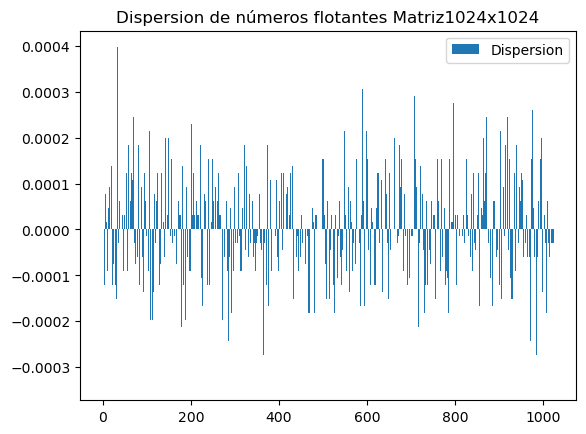

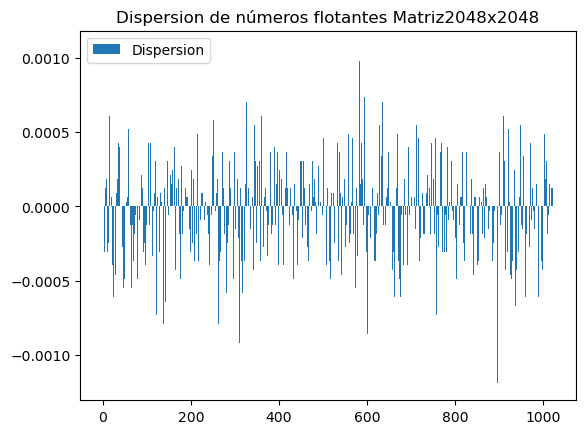

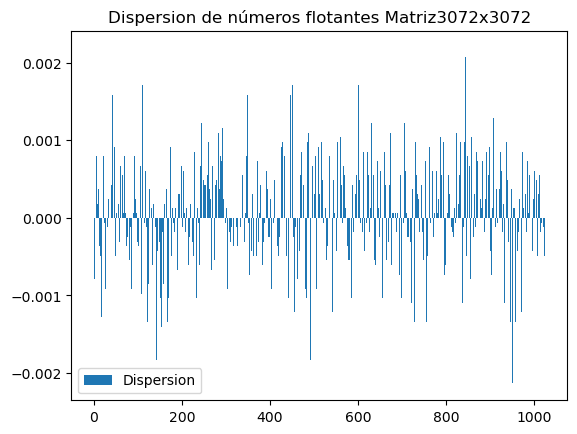

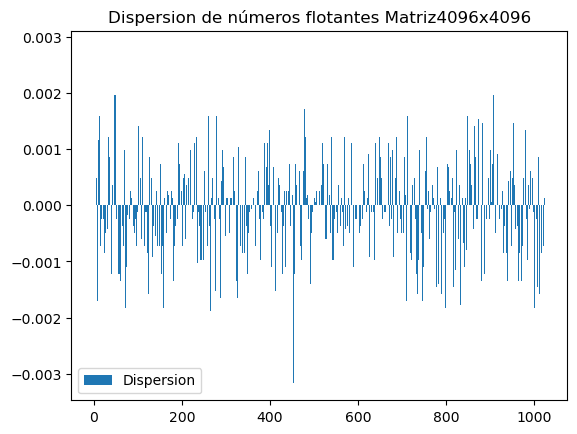

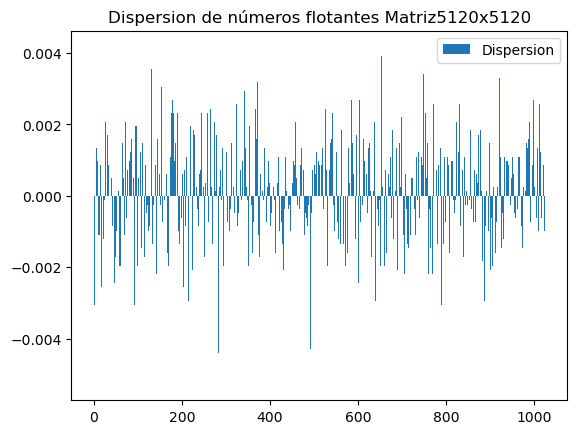

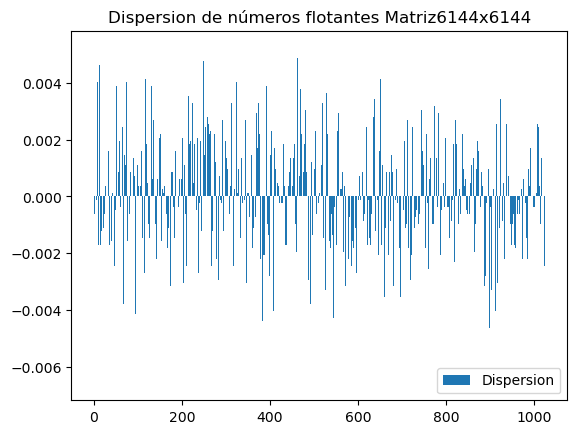

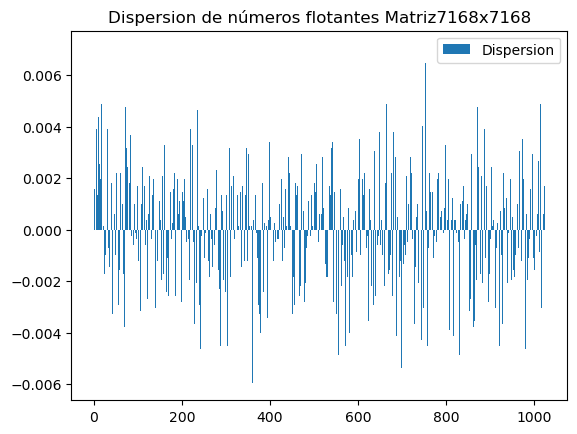

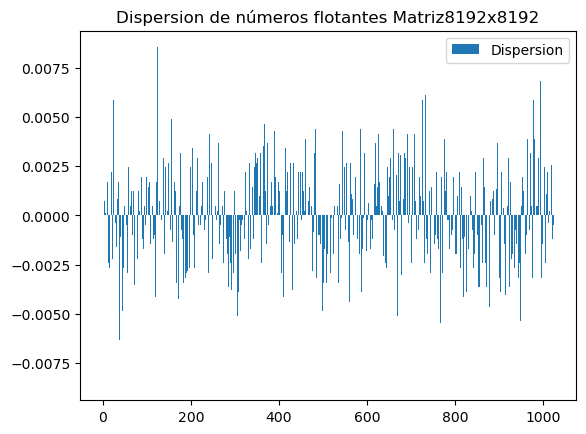

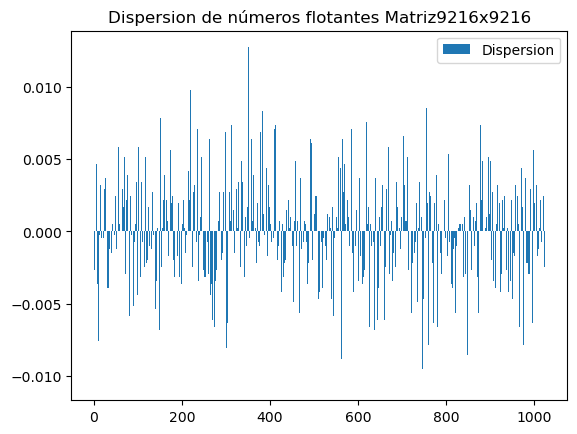

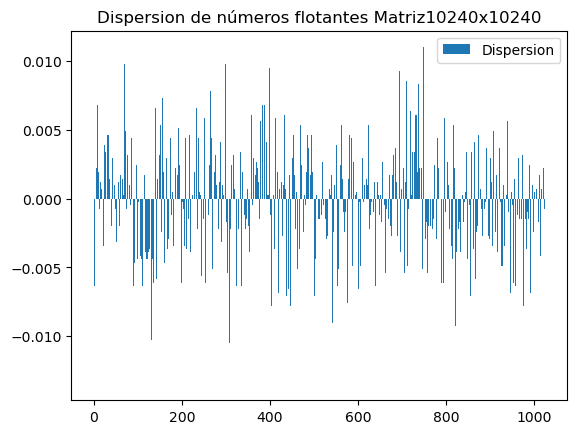

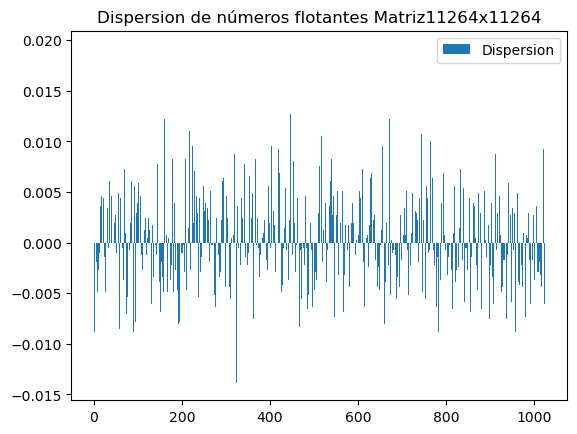

ValueError: x and y must have same first dimension, but have shapes (1024,) and (11,)

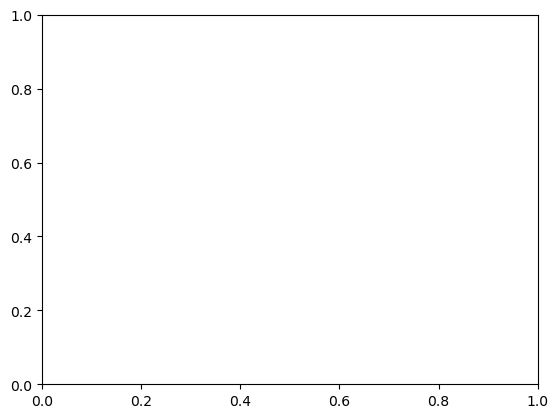

In [100]:
compare_mat_mult(True)

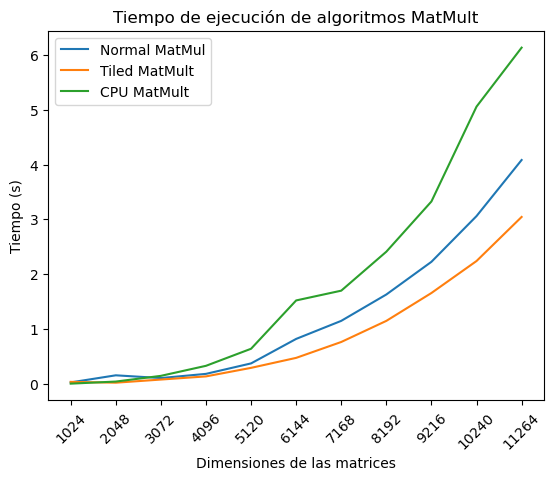

In [103]:
compare_mat_mult()

In [79]:
times_tiled = [0.0009992122650146484, 0.001001119613647461, 0.0020008087158203125,0.0009992122650146484, 0.0020003318786621094,0.0010006427764892578,0.002001047134399414,0.00099945068359375,0.002001047134399414, 0.0020003318786621094,0.0010001659393310547]
times_normal = [0.0010008811950683594,0.0010008811950683594,0.0020012855529785156, 0.0010023117065429688, 0.002000570297241211,0.0009987354278564453,0.0010004043579101562,0.002001523971557617,0.0010013580322265625, 0.0010001659393310547,0.002000570297241211]
times_CPU = [0.011510848999023438, 0.05301094055175781,0.15403485298156738, 0.3183891773223877,0.6391427516937256, 1.0227441787719727,1.670656442642212,2.5440258979797363,3.540357828140259,4.928776741027832,6.090865850448608]

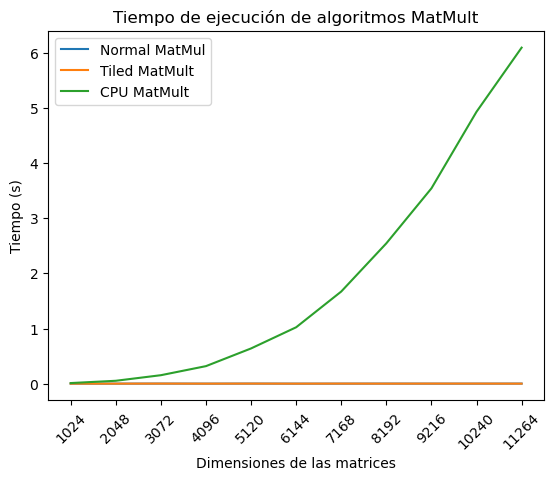

In [96]:
plt.plot(x, times_normal, label='Normal MatMul')
plt.plot(x, times_tiled, label='Tiled MatMult')
plt.plot(x, times_CPU, label='CPU MatMult')
plt.title('Tiempo de ejecución de algoritmos MatMult')
plt.xticks(x, rotation=45)
plt.xlabel('Dimensiones de las matrices')
plt.ylabel('Tiempo (s)')
plt.legend(loc='best')
plt.show()

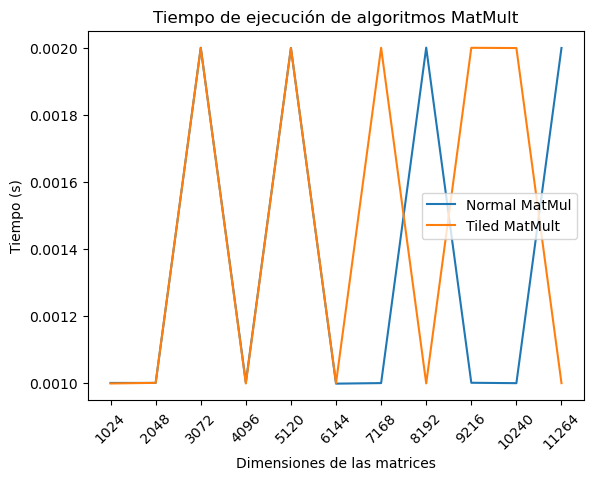

In [107]:
crop = 11
plt.plot(x[:crop], times_normal[:crop], label='Normal MatMul')
plt.plot(x[:crop], times_tiled[:crop], label='Tiled MatMult')
plt.title('Tiempo de ejecución de algoritmos MatMult')
plt.xticks(x[:crop],rotation=45)
plt.xlabel('Dimensiones de las matrices')
plt.ylabel('Tiempo (s)')
plt.legend(loc='best')
plt.show()